# Plotting line lists and spectra

SpecpolFlow includes a couple functions for easily plotting line lists and spectra.

The plots these functions generate are pretty good, particularly for a quick look.  However, for more advanced plots you may wish to make your own plots from scratch.  For plotting line lists, there are wide variety of approaches one can use, and you may wish to consider using alternative packages such as `lineid_plot` (see their [webpage](https://lineid-plot.readthedocs.io/) and [GitHub](https://github.com/phn/lineid_plot/)).

## A quick look from the command line

The quickest option is to use the command line tool `spf-plotspec`.   Running the command `spf-plotspec -h` provides some help information about this tool.  This can plot 2 and 3 column spectra (intensity only) and 6 column spectra (intensity and polarization).  The line lists are in a VALD "extract stellar", "long" format.  In the simplest case you can just run:
```
spf-plotspec observation_file.s -l line_list_file.dat
```
Both the line list and the observation are optional.  You can also plot multiple observation files, and you can include the `-g` flag to generate a legend with the file names:
```
spf-plotspec observation_file_1.s observation_file_2.s observation_file_3.s -l line_list_file.dat -g
```
You can plot lines with only depth values greater than a threshold with the `-d` flag:
```
spf-plotspec observation_file.s -l line_list_file.dat -d 0.1
```
Errorbars can be included in the plot with the `-e` flag.  The polarization spectrum can be plotted with `-s V`, and both Stokes I and the polarization can be plotted with `-s IV`:
```
spf-plotspec observation_file.s -l line_list_file.dat -d 0.1 -e -s IV
```

The plotting window has a couple key commands beyond the normal matplotlib options.  The arrow keys pan the plot.  The `i` and `o` keys zoom in and out.  The `a` key auto-scales both axes, and `A` auto-scales only the y-axis (useful if the x range is good but y is too zoomed in).

## Plotting spectra and line lists with plot_obs_lines()

Within the Python interface for SpecpolFlow, a tool for quickly plotting an observation and/or line list is the `plot_obs_lines()` function.  There is also a function for just plotting line lists, with more flexibility, in the `plot_lineList()` function, discussed below.  

First import `specpolFlow` and any other packages (in this case matplotlib).

In [1]:
## Importing Necessary Packages
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt

Then you can run the `plot_obs_lines()` with a spectrum, or a list of spectra, and a line list, or list of line lists.  You can either provide file names for spectrum and/or line list files, or you can provide SpecpolFlow Spectrum objects and LineList objects.  The function returns a matplotlib figure and an axes object.  Here is an example with couple files.

  Attempting to correct, assuming an observation in nm and a line list in A
  Scaling the line list wavelengths by 0.1


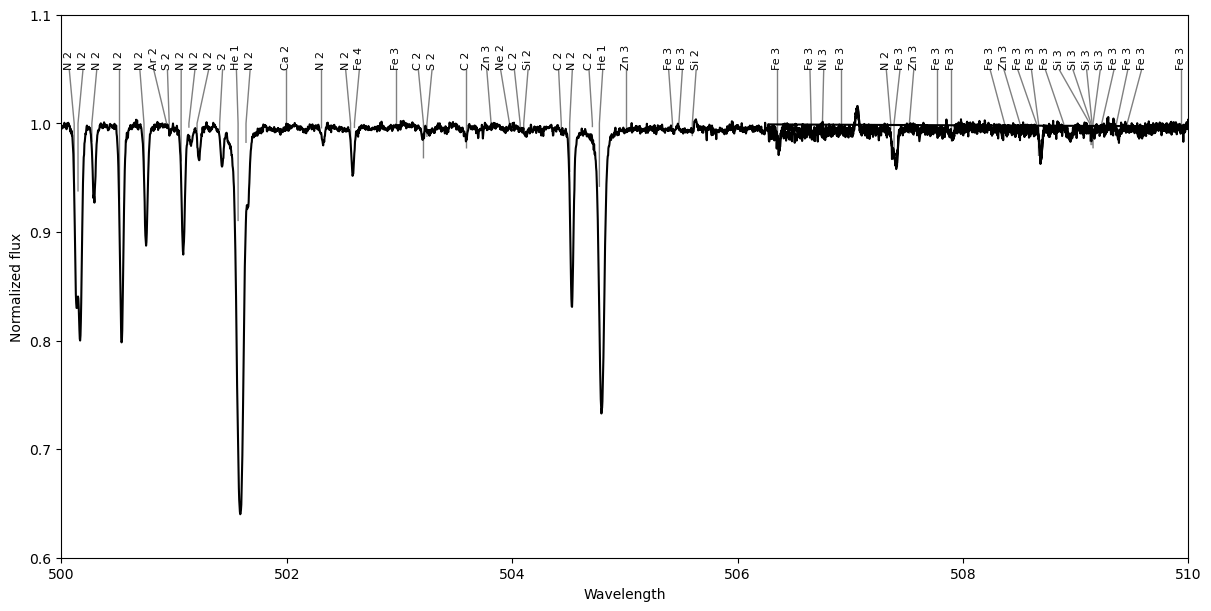

In [2]:
fig, ax = pol.plot_obs_lines('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s', 
                             lineList='../GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat')
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.1)
plt.show()

In this example, there is a warning message because our observation is in units of nm, while the line list is in A.  The function makes a guess about that and attempts to correct it, but it is safer to make sure the units are consistent.  One way to do that is to read in the line list first, and convert the units of the LineList object.

In [3]:
lineList = pol.read_VALD('../GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat')
lineList.wl = 0.1*lineList.wl

We can limit the line list to only lines with stronger depths, as estimated by VALD, with the `depthCut` parameter.  

We can also plot a couple different observations by providing them as a list.  In this case the star is part of a binary, and you can see the lines shift over time.  And there is an option with `showLegend` to include a legend with the file names of those spectra.

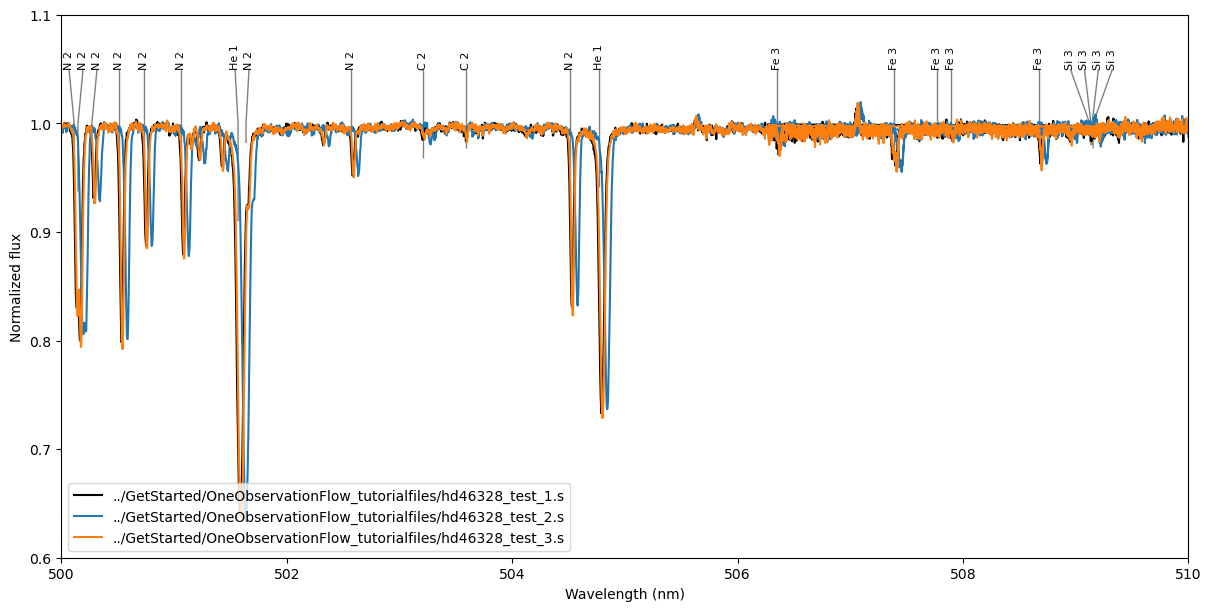

In [4]:
fig, ax = pol.plot_obs_lines(['../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s',
                              '../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_2.s',
                              '../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_3.s'],
                             lineList=lineList, showLegend=True,
                             depthCut=0.05)
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.1)
ax.set_xlabel('Wavelength (nm)')
plt.show()

We can also apply a doppler shift to the spectrum using `velSpec` or to the line list using `velLines` (for velocity in km/s).  If we look at one of the observations where the radial velocity of the star is higher this can be handy.  

We can also plot multiple line lists, for example here we make two line lists, one containing only He lines, the other containing everything else.  This could be handy for finding lines of a particular ion.  

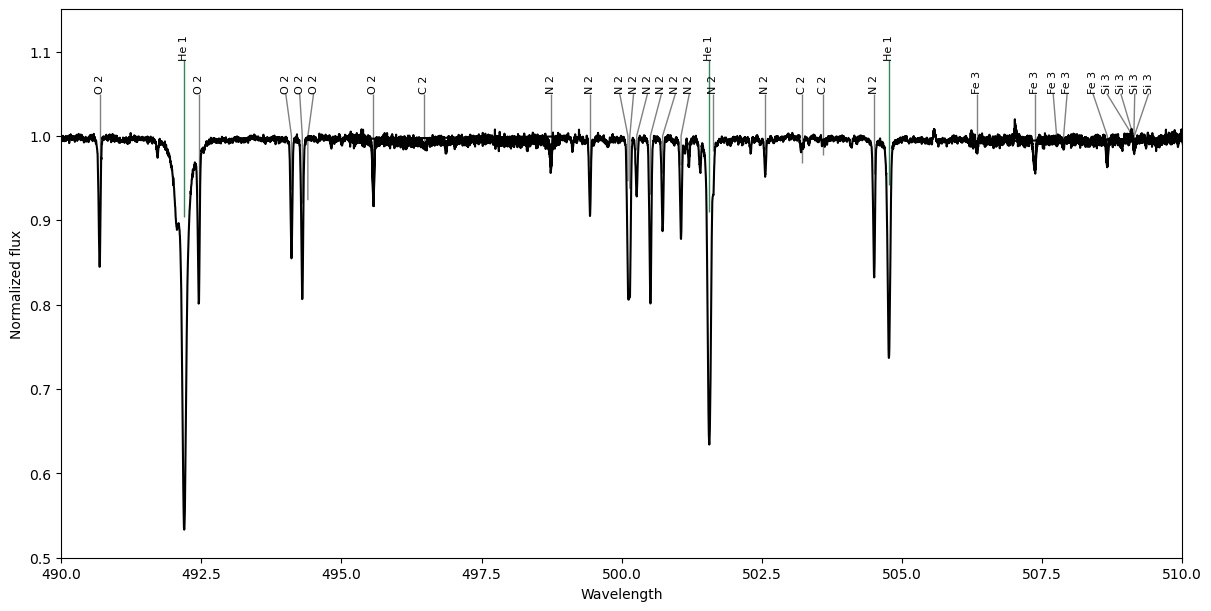

In [5]:
# Split the line list into He lines and other lines
isLineHe = (lineList.ion == 'He 1') | (lineList.ion == 'He 2')
lineListHe = lineList[isLineHe]
lineListOther = lineList[np.logical_not(isLineHe)]

# Plot the two line lists
fig, ax = pol.plot_obs_lines('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_2.s',
                             velSpec=-42.0,
                             lineList=[lineListOther, lineListHe],
                             depthCut=0.05)
ax.set_xlim(490.0, 510.0)
ax.set_ylim(0.5, 1.15)
plt.show()

There is an option for plotting Stokes V, Null 1, or Null 2.  There is also an option for plotting Stokes I and V spectra together, with the V spectrum shifted vertically above I.  This can be useful if you are searching for Stokes V signatures in individual lines.

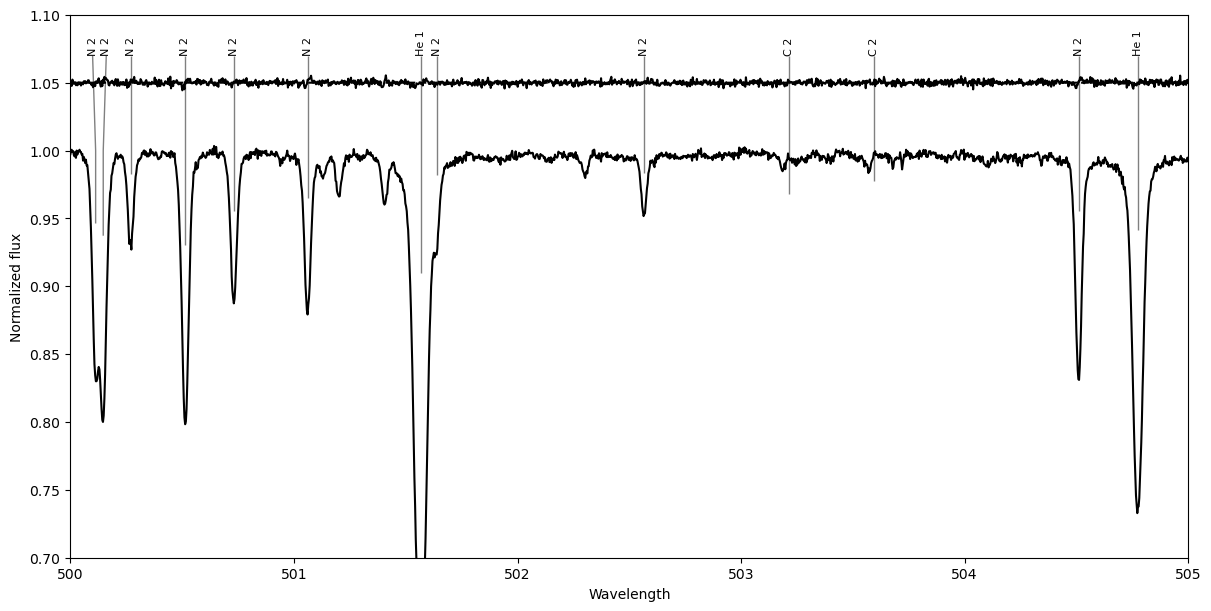

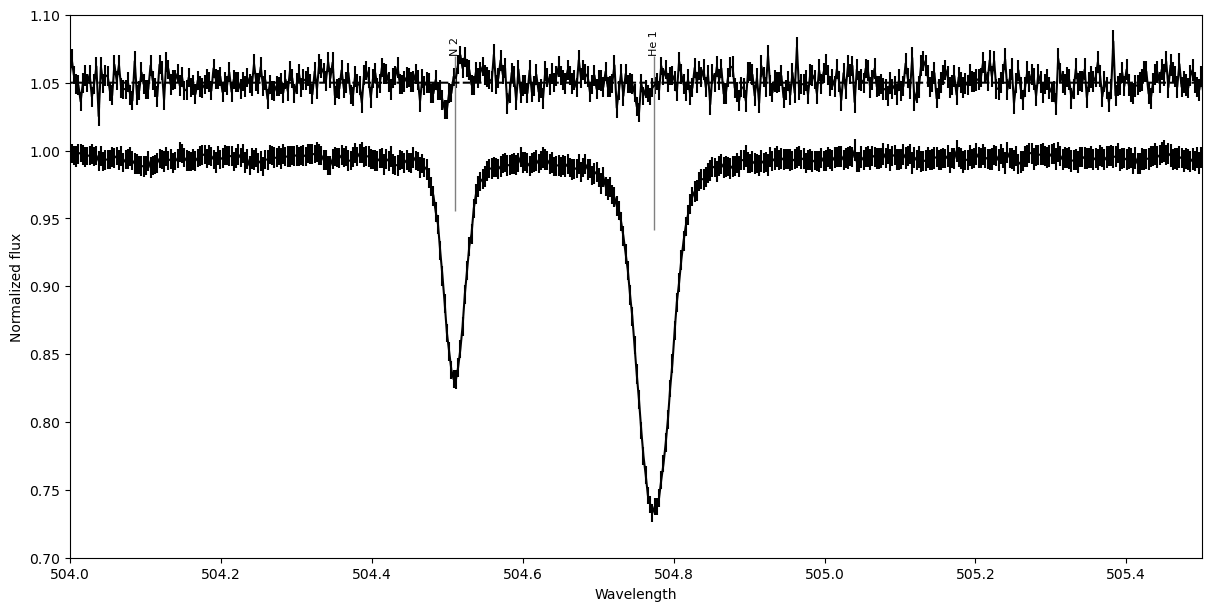

In [6]:
# plotting Stokes V
fig, ax = pol.plot_obs_lines('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s', velSpec=-12.0,
                             lineList=lineList, depthCut=0.05, 
                             stokes='IV')
ax.set_xlim(500.0, 505.0)
ax.set_ylim(0.7, 1.1)

# plotting Stokes V, but scaled up by a factor of 5, and showing errorbars
spec = pol.read_spectrum('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s')
spec.specV = spec.specV*5.0
spec.specN1 = spec.specN1*5.0
spec.specSig = spec.specSig*5.0
fig, ax = pol.plot_obs_lines(spec, velSpec=-12.0,
                             lineList=lineList, depthCut=0.05, 
                             stokes='IV', showErr=True)
ax.set_xlim(504.0, 505.5)
ax.set_ylim(0.7, 1.1)
plt.show()

This can also be useful for comparing synthetic spectra to observations.  If the model is in a 2 column format (or 3 or 6, with normalized flux as the second column), then you can just use `pol.plot_obs_lines(['observation_file', 'model_file'], lineList='linelist_file')`.  If the model file is in a more complex format, you can still pack it into a Spectrum object and plot that.  

## Plotting line lists with plot_lineList()

The `plot_lineList()` as a function for plotting a line list, and it has a lot of formatting options.  It will either make a new matplotlib figure and axes if none is provided, or you can provide an axes object for the line list to be drawn in.  It provides options for how and where line labels are drawn, as well as how tick marks are drawn.

In a basic case it can be used similarly to the above examples.  In this example, we plot the observation with matplotlib, then add the a plot of the line list to that matplotlib axes object using `plot_lineList()`.

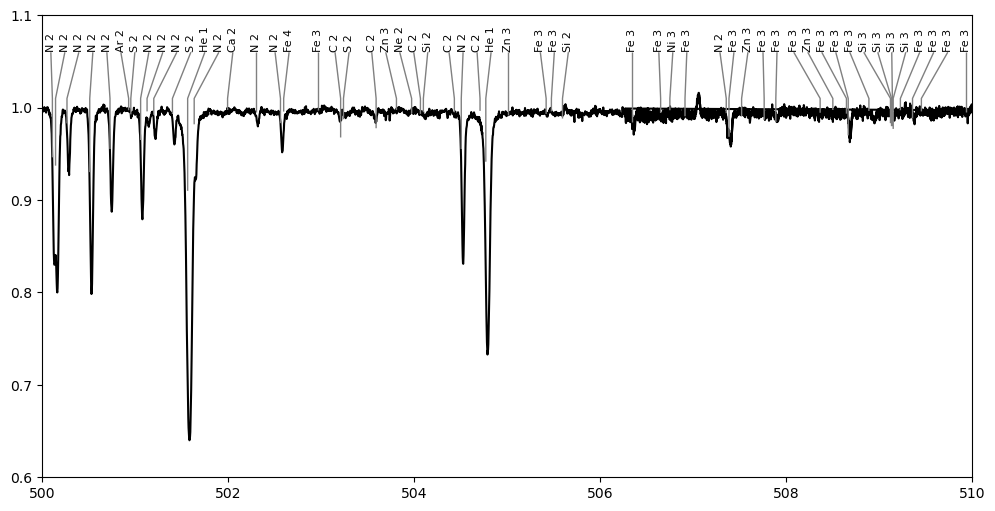

In [7]:
# Read an observation and a line list, and shift them all into units of nm
spec = pol.read_spectrum('../GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s')
lineList = pol.read_VALD('../GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat')
lineList.wl = 0.1*lineList.wl

# plot the observation
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spec.wl, spec.specI, 'k')
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.1)

# plot the line list, using the same axes as the observation
pol.plot_lineList(lineList, ax=ax)
plt.show()

With this function we can change the color of the tick marks (using `linecolor`) and the labels (using `color`), rotate the labels horizontally (using `rotation`), and use a roman numeral for the ionization stage (using `romanIon`).  We also apply a depth cutoff (using `depthCut`), selecting only lines with a depth estimate greater than this value, to only get the more important labels.

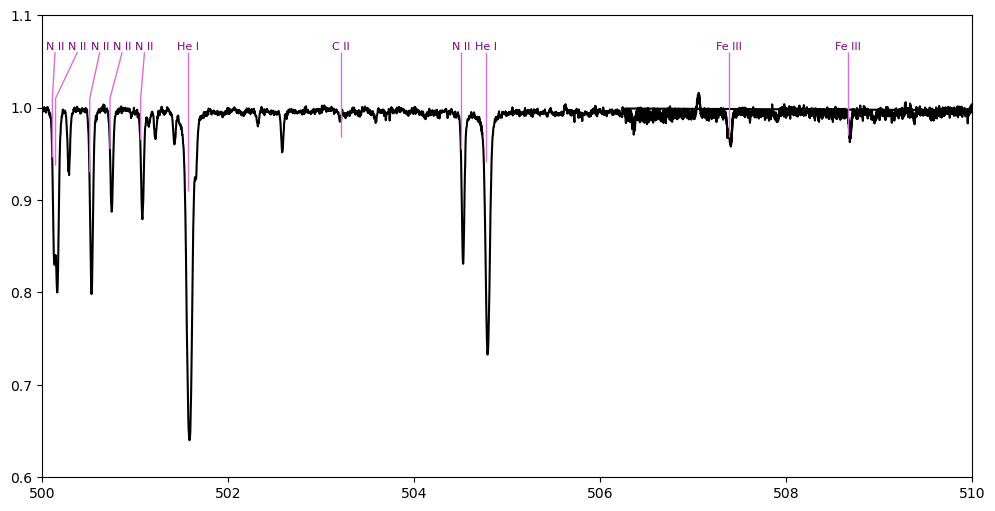

In [8]:
# plot the observation
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spec.wl, spec.specI, 'k')
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.1)

# plot the line list, using the same axes as the observation
pol.plot_lineList(lineList, depthCut=0.1, 
                  linecolor='orchid', color='purple',
                  rotation='horizontal', romanIon=True,
                  ax=ax)
plt.show()

You can change how deep the tickmarks are with `scaleDepths`, how high up the tick marks are drawn with `cont`, and how high above that the labels are placed with `rise`.  The label font size can be changed with `fontsize` and spacing between labels can be changed with `padding`.  The tick marks are drawn down to a value proportional to the depth value of the line.  If you want all tick marks drawn down to the same point, you can set the depth values all to the same value (e.g. `lineList.depth[:] = 0.5`), although in this case the `depthCut` to only show stronger lines will not work.  

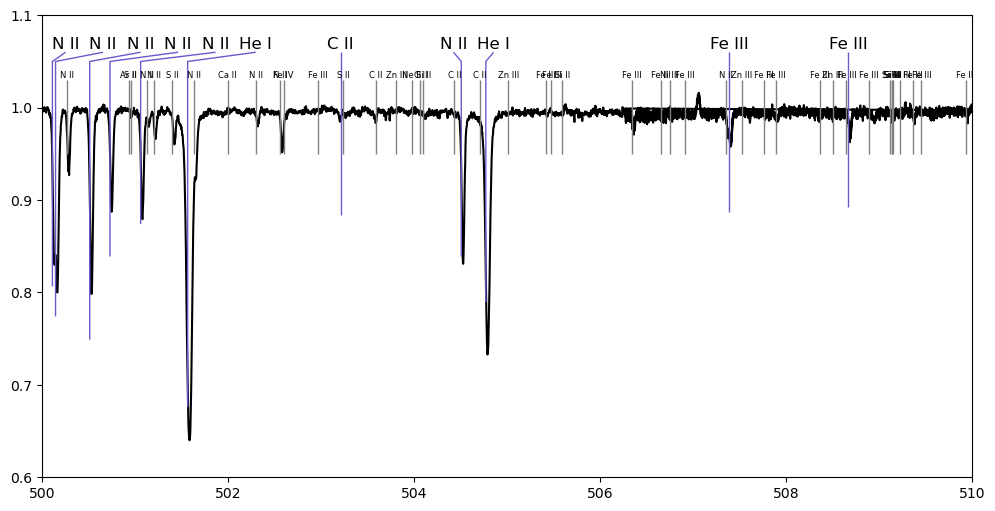

In [9]:
# plot the observation
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spec.wl, spec.specI, 'k')
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.1)

# plot the line list, showing stronger lines with big symbols
pol.plot_lineList(lineList, depthCut=0.1, 
                  rotation='horizontal', romanIon=True,
                  scaleDepths=0.9, linecolor='slateblue',
                  cont=1.05, rise=0.01,
                  fontsize=12.0, padding=10.0,
                  ax=ax)
# and plot a second line list showing only the weaker lines
lineList2 = lineList[lineList.depth < 0.1]
lineList2.depth[:] = 0.2
pol.plot_lineList(lineList2,
                  rotation='horizontal', romanIon=True,
                  cont=1.01, rise=0.02, fontsize=6.0,
                  ax=ax)
plt.show()

If you are trying to fit a lot of labels onto a plot, you can also include multiple rows of labels using `nrows`, although this can be visually a bit more confusing. 

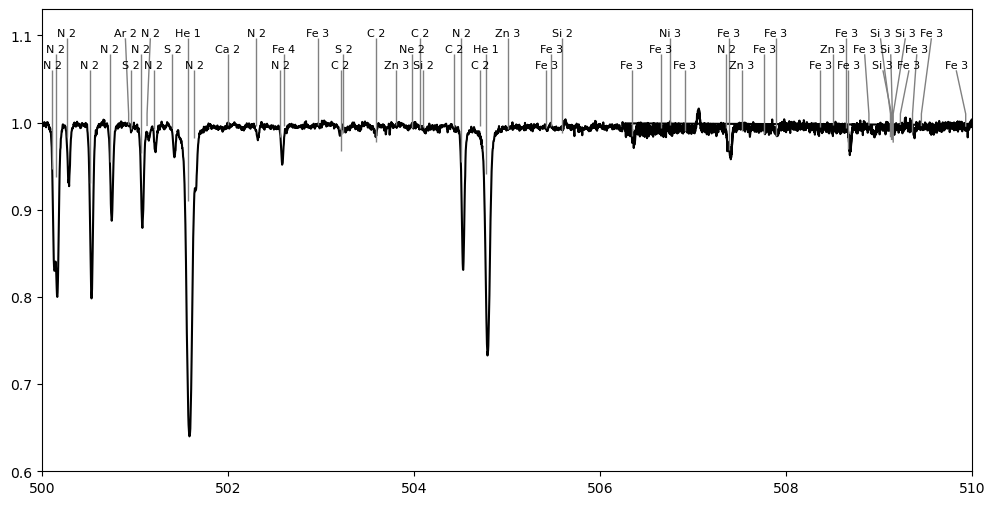

In [10]:
# plot the observation
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spec.wl, spec.specI, 'k')
ax.set_xlim(500.0, 510.0)
ax.set_ylim(0.6, 1.13)

# plot the line list, using the same axes as the observation
pol.plot_lineList(lineList, rotation='horizontal',
                  nrows=3,
                  ax=ax)
plt.show()

If you are trying to plot a very large number of lines and labels, then drawing all the labels can become quite slow.  To keep the function running fast, the number of labels drawn can be limited with `maxLabels`.  When this is used, only that many of the strongest lines will have labels drawn, but tick marks will still be drawn for all labels.  The `plot_obs_lines()` function by default limits `maxLabels` to 100, but the `plot_lineList` function will try to plot all labels by default.  

When too many labels are drawn, they will start to overlap on the plot.  If the function can avoid overlapping by shifting labels horizontally it will, but if it cannot labels are just drawn at the position of lines.

In this example we plot lines for a large region of spectrum, but limit the number of labels drawn.

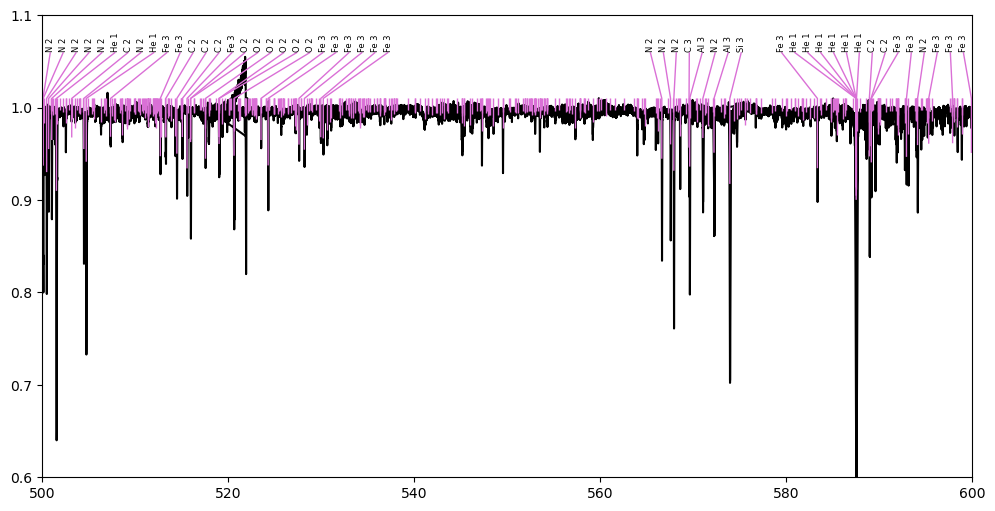

In [11]:
# plot the observation
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spec.wl, spec.specI, 'k')
ax.set_xlim(500.0, 600.0)
ax.set_ylim(0.6, 1.1)

# plot the line list, using the same axes as the observation
pol.plot_lineList(lineList, linecolor='orchid',
                  maxLabels=50, fontsize=6,
                  ax=ax)
plt.show()

When there is an interactive matplotlib window, the `plot_lineList` function binds several keys (arrow keys to panning, `i` and `o` to zoom in and out, `a` autoscale the axes, `A` autoscale just the y-axis, and `z` activate matplotlib's zoom tool). This uses matplotlib's event handling and callback tools. To prevent this behaviour, e.g. for embedding inside another program, use the `bindKeys=False` option.  